<a href="https://colab.research.google.com/github/subhadeepk/cse437-assignments/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [ ]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap
env.reset()
for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")

env.close()

Episode 1: total reward = -1585
Episode 2: total reward = -1486
Episode 3: total reward = -694
Episode 4: total reward = -1783
Episode 5: total reward = -595


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [ ]:
import gymnasium as gym
import numpy as np
import random

# ---- Reproducibility ----
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

env = gym.make("CliffWalking-v1")
env.reset(seed=SEED)
try:
    env.action_space.seed(SEED)
except AttributeError:
    pass

# SARSA parameters
alpha = 0.1
gamma = 0.95
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions), dtype=np.float64)

# ε schedule (episode-wise exponential decay)
eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-2

n_episodes = 500
max_steps = 200


returns = []  # episode returns

def eps_greedy(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    return int(np.argmax(Q[state]))

for ep in range(n_episodes):
    s, _ = env.reset()
    eps = max(eps_min, eps * (1 - eps_decay))  # tiny per-step decay
    if ep>300:
      eps = 0

    a = eps_greedy(s, eps)
    ep_return = 0.0

    for t in range(max_steps):
        s_next, r, terminated, truncated, _ = env.step(a)
        ep_return += r
        done = terminated or truncated

        # choose a' only if not terminal
        if not done:
            a_next = eps_greedy(s_next, eps)

        td_target = r + (0.0 if done else gamma * Q[s_next, a_next])
        Q[s, a] += alpha * (td_target - Q[s, a])

        if done:
            break

        s, a = s_next, a_next

    returns.append(ep_return)



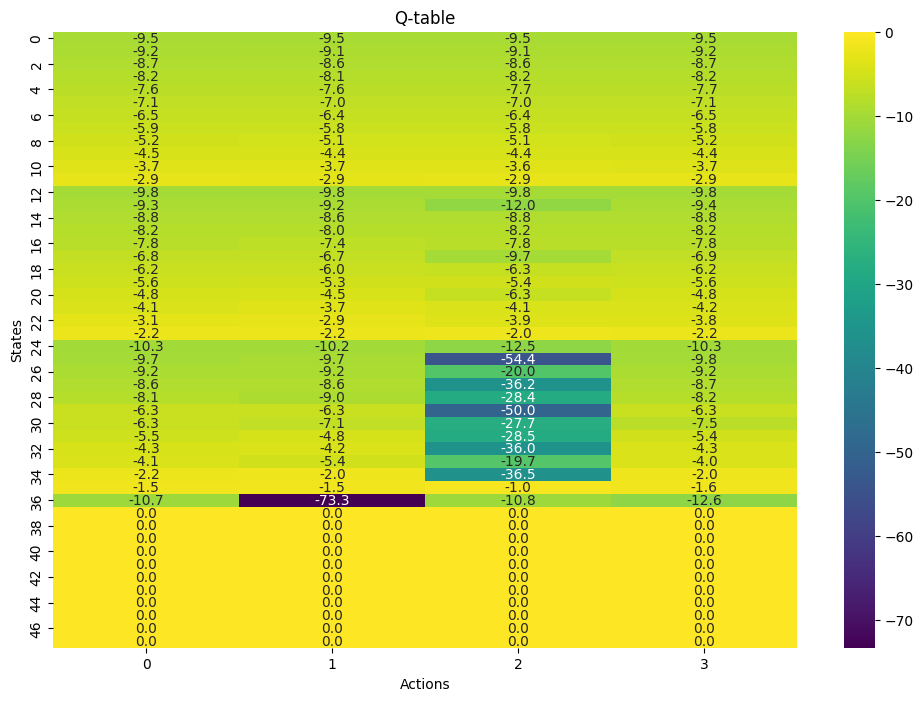

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

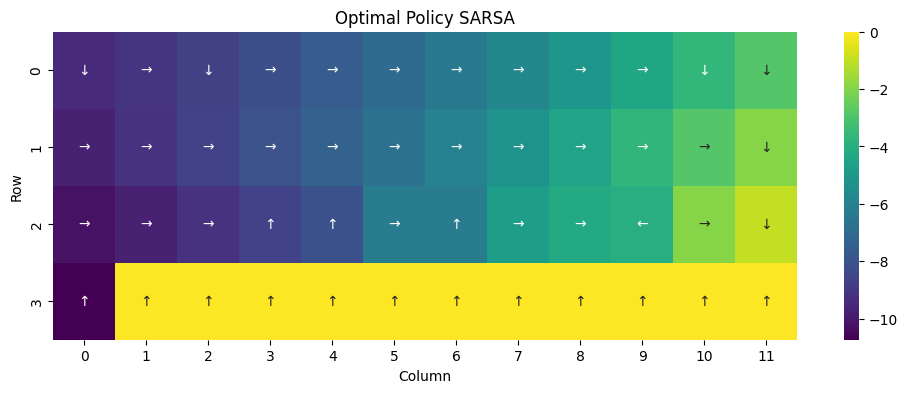

In [ ]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title(f"Optimal Policy {title}")
  plt.show()
plot_policy(Q)

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [ ]:
import gymnasium as gym
import numpy as np
import random

env = gym.make("CliffWalking-v1")

alpha = 0.1
gamma = 0.95
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))
q_learning_rewards = []

n_episodes = 500
max_steps = 100

# epsilon schedule (episode-wise exponential decay)
eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-4

def eps_greedy(s, eps):
    if random.random() < eps:
        return env.action_space.sample()
    return int(np.argmax(Q[s]))

for ep in range(n_episodes):
    s, _ = env.reset()
    # decay epsilon per episode
    # eps = eps_min + (eps_max - eps_min) * np.exp(-eps_decay * ep)
    eps = max(eps_min, eps * (1 - eps_decay))  # tiny per-step decay

    if ep>300:
      eps = 0

    episode_reward = 0

    a = eps_greedy(s, eps)

    for t in range(max_steps):
        s_next, r, terminated, truncated, _ = env.step(a)

        # if ep == n_episodes - 1:
        #     q_learning_rewards.append(r)

        episode_reward += r

        # Q update
        if terminated or truncated:
            Q[s, a] += alpha * (r - Q[s, a])
            break

        # choose a' as the best action
        a_next = np.argmax(Q[s_next])

        # Q update
        td_target = r + gamma * Q[s_next, a_next]
        Q[s, a] += alpha * (td_target - Q[s, a])

        s, a = s_next, a_next

    q_learning_rewards.append(episode_reward)


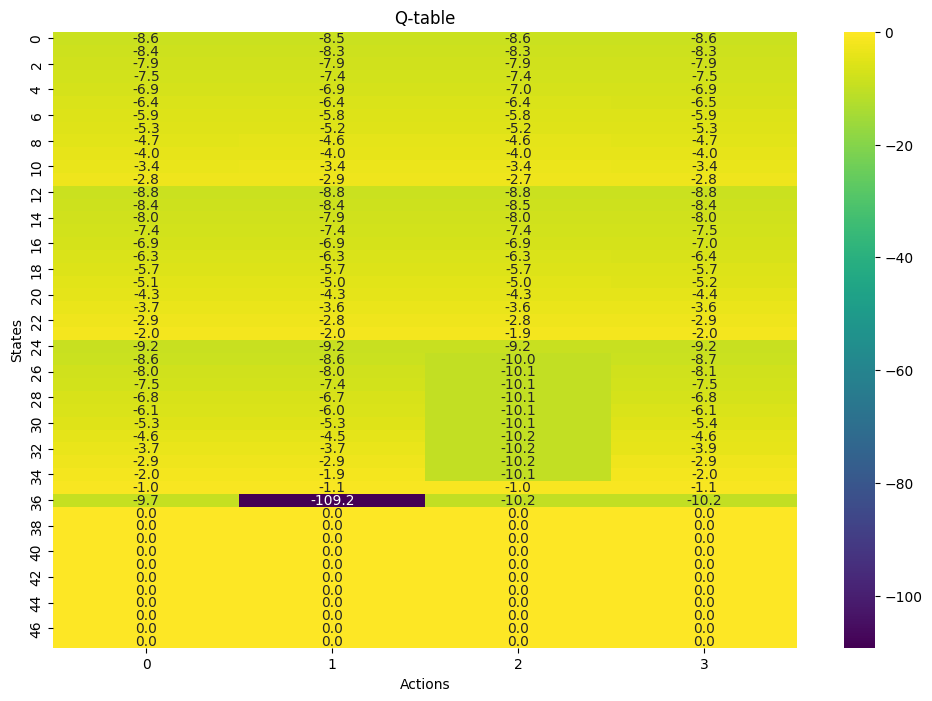

In [ ]:
plot_Q(Q)

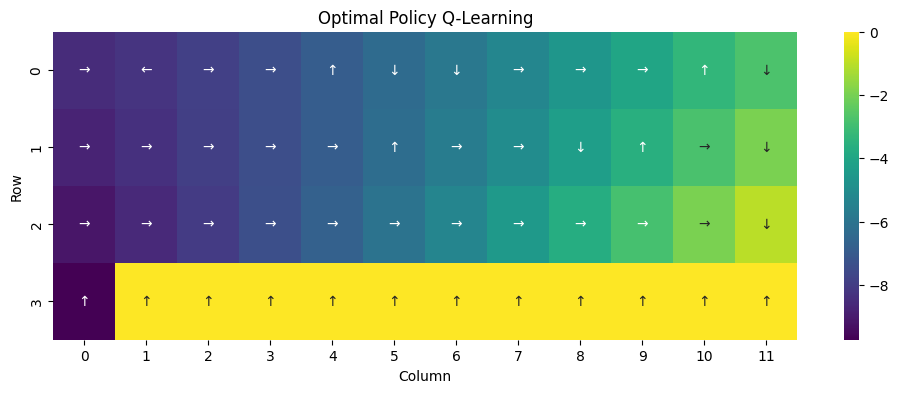

In [ ]:
plot_policy(Q, title = "Q-Learning")

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


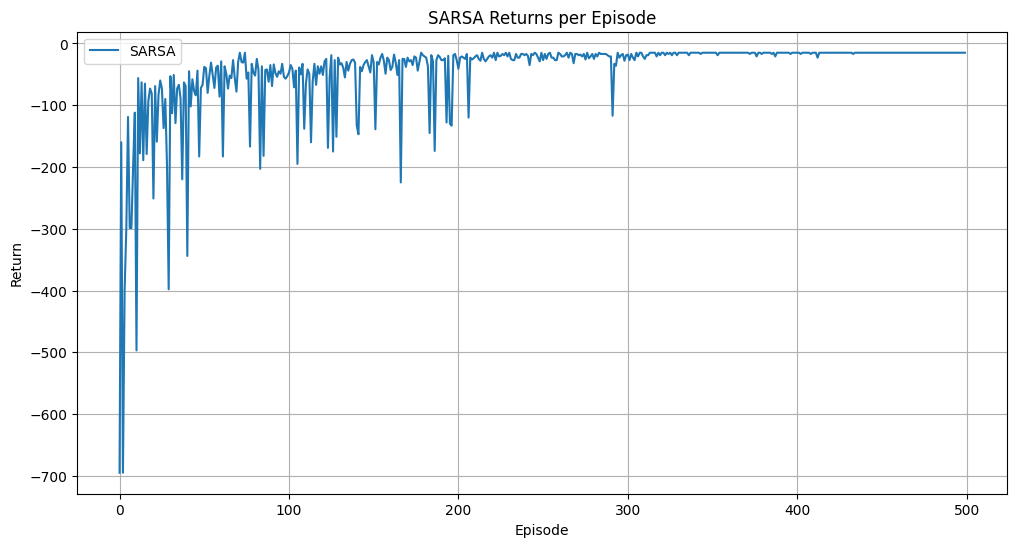

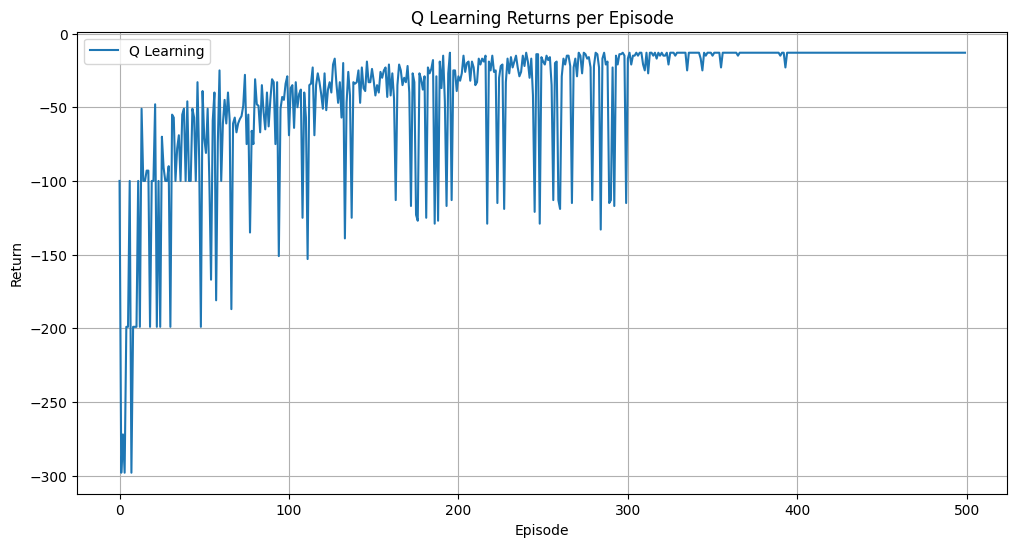

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(returns, label="SARSA")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA Returns per Episode")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(12, 6))
plt.plot(q_learning_rewards, label="Q Learning")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Q Learning Returns per Episode")
plt.legend()
plt.grid(True)
plt.show()

# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?


In [44]:
## Install https://github.com/damat-le/gym-simplegrid
!pip install gym_simplegrid

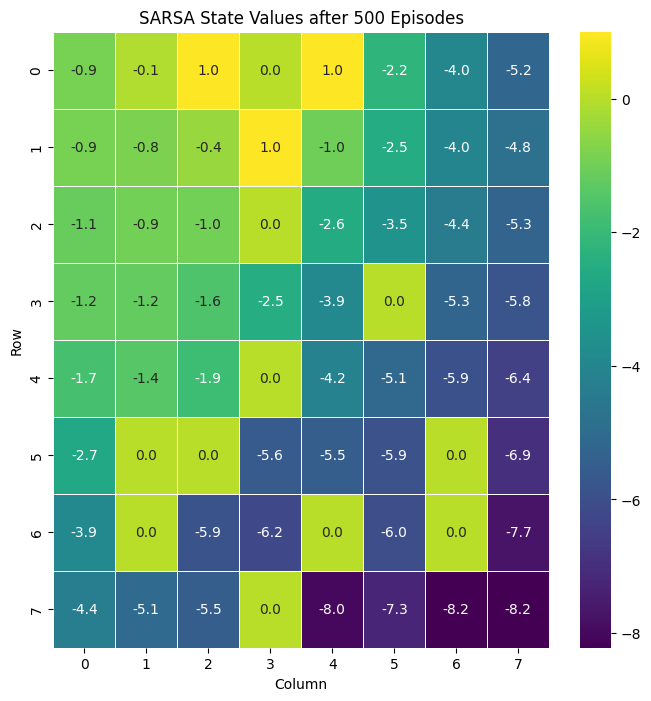

In [85]:
import gymnasium as gym
import gym_simplegrid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Env & config -----
gamma = 0.99
START_LOC = 15
GOAL_LOC  = 3
NUM_EPISODES = 500
MAX_STEPS = 1000

options = {"start_loc": START_LOC, "goal_loc": GOAL_LOC}
env = gym.make("SimpleGrid-8x8-v0", render_mode=None)

n_states = 64
n_actions = env.action_space.n  # usually 4 (up/down/left/right)
Q = np.zeros((n_states, n_actions), dtype=np.float64)

alpha = 0.1
eps = 1
eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-5  # gentle per-episode decay

def eps_greedy(s, eps):
    if np.random.rand() < eps:
        return env.action_space.sample()
    return int(np.argmax(Q[s]))

returns = []

for ep in range(NUM_EPISODES):
    obs, info = env.reset(seed=ep+1, options=options)
    s = int(obs)

    eps = max(eps_min, eps_min + (eps_max - eps_min) * np.exp(-eps_decay * ep))

    ep_return = 0.0
    a = eps_greedy(s, eps)

    for t in range(MAX_STEPS):



        next_obs, r, terminated, truncated, info = env.step(a)
        s_next = int(next_obs)
        ep_return += r
        done = terminated or truncated
        a_next = eps_greedy(s_next, eps)
        td_target = r + gamma * Q[s_next, a_next]

        if not done:
            a_next = eps_greedy(s_next, eps)
            td_target = r + gamma * Q[s_next, a_next]
        else:
            td_target = r  # no bootstrap at terminal

        Q[s, a] += alpha * (td_target - Q[s, a])

        if done:
            break

        s, a = s_next, a_next


    returns.append(ep_return)

# env.close()

# ----- Derive V(s) = max_a Q(s,a) and plot -----
V = np.max(Q, axis=1)
V_grid = V.reshape(8, 8)

plt.figure(figsize=(8, 8))
sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5)
algo_name = "SARSA" if USE_SARSA else "Q-learning"
plt.title(f"{algo_name} State Values after {NUM_EPISODES} Episodes")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()
